### Content Based Recommendations

In the previous notebook, you were introduced to a way of making recommendations using collaborative filtering.  However, using this technique there are a large number of users who were left without any recommendations at all.  Other users were left with fewer than the ten recommendations that were set up by our function to retrieve....

In order to help these users out, let's try another technique: **content based** recommendations. Let's start off where we were in the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import HTML
!pip install progressbar
import progressbar
import tests as t
import pickle


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']


all_recs = pickle.load(open("data/all_recs.p", "rb"))

smart-open 1.6.0 requires bz2file, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Datasets

From the above, you now have access to three important items that you will be using throughout the rest of this notebook.  

`a.` **movies** - a dataframe of all of the movies in the dataset along with other content related information about the movies (genre and date)


`b.` **reviews** - this was the main dataframe used before for collaborative filtering, as it contains all of the interactions between users and movies.


`c.` **all_recs** - a dictionary where each key is a user, and the value is a list of movie recommendations based on collaborative filtering

For the individuals in **all_recs** who did receive 10 recommendations using collaborative filtering, we don't really need to worry about them.  However, there were a number of individuals in our dataset who did not receive any recommendations.

-----

`1.` Let's start with finding all of the users in our dataset who didn't get all 10 ratings we would have liked them to have using collaborative filtering.  

In [2]:
user_list = reviews.user_id.unique()

In [3]:
users_with_all_recs = [user for user in list(all_recs.keys()) if (len(all_recs[user])>=10)]

In [4]:
len(user_list)

53968

In [5]:
len(users_with_all_recs) # Store user ids who have all their recommendations in this (10 or more)

22187

In [6]:
users_who_need_recs = np.setdiff1d(user_list,users_with_all_recs,assume_unique=True)

In [7]:
len(users_who_need_recs) # Store users who still need recommendations here

31781

In [8]:
# A quick test
assert len(users_with_all_recs) == 22187
print("That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!")

That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!


### Content Based Recommendations

You will be doing a bit of a mix of content and collaborative filtering to make recommendations for the users this time.  This will allow you to obtain recommendations in many cases where we didn't make recommendations earlier.     

`2.` Before finding recommendations, rank the user's ratings from highest to lowest. You will move through the movies in this order looking for other similar movies.

In [9]:
reviews.head(10)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2,454876,8,1394818630,2014-03-14 17:37:10,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,790636,7,1389963947,2014-01-17 13:05:47,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,2,816711,8,1379963769,2013-09-23 19:16:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,2,1091191,7,1391173869,2014-01-31 13:11:09,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,2,1103275,7,1408192129,2014-08-16 12:28:49,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,2,1322269,7,1391529691,2014-02-04 16:01:31,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,2,1390411,8,1451374513,2015-12-29 07:35:13,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [10]:
# create a dataframe similar to reviews, but ranked by rating for each user
reviews_descend = reviews.sort_values(by=['user_id','rating','timestamp'],ascending=[True,False,False])

In [11]:
reviews_descend_short = reviews_descend[['user_id','movie_id','rating']]

In [13]:
reviews_descend_short.head()

,user_id,movie_id,rating
0,1,68646,10
1,1,113277,10
16,2,1798709,10
18,2,2024544,10
22,2,2726560,9


In [15]:
reviews_descend.head()

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16,2,1798709,10,1389948338,2014-01-17 08:45:38,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18,2,2024544,10,1389355949,2014-01-10 12:12:29,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
22,2,2726560,9,1438293988,2015-07-30 22:06:28,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
reviews_descend.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'date', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year_2013',
       'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018'],
      dtype='object')

In [17]:
movies.head(2)

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Similarities

In the collaborative filtering sections, you became quite familiar with different methods of determining the similarity (or distance) of two users.  We can perform similarities based on content in much the same way.  

In many cases, it turns out that one of the fastest ways we can find out how similar items are to one another (when our matrix isn't totally sparse like it was in the earlier section) is by simply using matrix multiplication.  If you are not familiar with this, an explanation is available [here by 3blue1brown](https://www.youtube.com/watch?v=LyGKycYT2v0) and another quick explanation is provided [in the post here](https://math.stackexchange.com/questions/689022/how-does-the-dot-product-determine-similarity).

For us to pull out a matrix that describes the movies in our dataframe in terms of content, we might just use the indicator variables related to **year** and **genre** for our movies.  

Then we can obtain a matrix of how similar movies are to one another by taking the dot product of this matrix with itself.  Notice below that the dot product where our 1 values overlap gives a value of 2 indicating higher similarity.  In the second dot product, the 1 values don't match up.  This leads to a dot product of 0 indicating lower similarity.

<img src="images/dotprod1.png" alt="Dot Product" height="500" width="500">

We can perform the dot product on a matrix of movies with content characteristics to provide a movie by movie matrix where each cell is an indication of how similar two movies are to one another.  In the below image, you can see that movies 1 and 8 are most similar, movies 2 and 8 are most similar, and movies 3 and 9 are most similar for this subset of the data.  The diagonal elements of the matrix will contain the similarity of a movie with itself, which will be the largest possible similarity (and will also be the number of 1's in the movie row within the orginal movie content matrix).

<img src="images/moviemat.png" alt="Dot Product" height="500" width="500">


`3.` Create a numpy array that is a matrix of indicator variables related to year (by century) and movie genres by movie.  Perform the dot product of this matrix with itself (transposed) to obtain a similarity matrix of each movie with every other movie.  The final matrix should be 31245 x 31245.

In [18]:
movies.columns

Index(['movie_id', 'movie', 'genre', 'date', '1800's', '1900's', '2000's',
       'History', 'News', 'Horror', 'Musical', 'Film-Noir', 'Mystery',
       'Adventure', 'Sport', 'War', 'Music', 'Reality-TV', 'Adult', 'Crime',
       'Family', 'Drama', 'Talk-Show', 'Biography', 'Sci-Fi', 'Fantasy',
       'Romance', 'Game-Show', 'Action', 'Documentary', 'Animation', 'Comedy',
       'Short', 'Western', 'Thriller'],
      dtype='object')

In [19]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_dummy_var = movies[["1800's", "1900's", "2000's",
       'History', 'News', 'Horror', 'Musical', 'Film-Noir', 'Mystery',
       'Adventure', 'Sport', 'War', 'Music', 'Reality-TV', 'Adult', 'Crime',
       'Family', 'Drama', 'Talk-Show', 'Biography', 'Sci-Fi', 'Fantasy',
       'Romance', 'Game-Show', 'Action', 'Documentary', 'Animation', 'Comedy',
       'Short', 'Western', 'Thriller']]


In [20]:
movie_ids_list = movies.movie_id.values

In [21]:
movies.head(3)

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,12,The Arrival of a Train (1896),Documentary|Short,1896,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [25]:
movie_dummy_var.head(3)

,1800's,1900's,2000's,History,News,Horror,Musical,Film-Noir,Mystery,Adventure,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [26]:
movie_dummy_var.columns

Index(['1800's', '1900's', '2000's', 'History', 'News', 'Horror', 'Musical',
       'Film-Noir', 'Mystery', 'Adventure', 'Sport', 'War', 'Music',
       'Reality-TV', 'Adult', 'Crime', 'Family', 'Drama', 'Talk-Show',
       'Biography', 'Sci-Fi', 'Fantasy', 'Romance', 'Game-Show', 'Action',
       'Documentary', 'Animation', 'Comedy', 'Short', 'Western', 'Thriller'],
      dtype='object')

In [29]:
movie_array = movie_dummy_var.values

In [30]:
movie_array

array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [31]:
#dot_prod_movies = np.matmul(movie_array, movie_array.T)  # very slow atleast 3x more than dot
dot_prod_movies = np.dot(movie_array, movie_array.T)

In [32]:
dot_prod_movies.shape

(31245, 31245)

In [33]:
dot_prod_movies

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 1],
       [0, 0, 0, ..., 2, 2, 1],
       [0, 0, 0, ..., 1, 1, 2]], dtype=int64)

In [34]:
dot_prod_movies_df = pd.DataFrame(dot_prod_movies, columns=movie_ids_list, index=movie_ids_list)

In [35]:
#movie_array2 = np.array(movie_dummy_var)

In [36]:
#movie_matrix = np.matrix(movie_dummy_var)

In [37]:
# %%timeit
# array_dot = np.dot(movie_array2, movie_array2.T)

In [38]:
# %%timeit
# matrix_dot = np.matmul(movie_array2, movie_array2.T)

In [39]:
# create checks for the dot product matrix
assert dot_prod_movies.shape[0] == 31245
assert dot_prod_movies.shape[1] == 31245
assert dot_prod_movies[0, 0] == np.max(dot_prod_movies[0])
print("Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!")

Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!


### For Each User...


Now you have a matrix where each user has their ratings ordered.  You also have a second matrix where movies are each axis, and the matrix entries are larger where the two movies are more similar and smaller where the two movies are dissimilar.  This matrix is a measure of content similarity. Therefore, it is time to get to the fun part.

For each user, we will perform the following:

    i. For each movie, find the movies that are most similar that the user hasn't seen.

    ii. Continue through the available, rated movies until 10 recommendations or until there are no additional movies.

As a final note, you may need to adjust the criteria for 'most similar' to obtain 10 recommendations.  As a first pass, I used only movies with the highest possible similarity to one another as similar enough to add as a recommendation.

`3.` In the cell below, complete each of the functions needed for making content based recommendations.

In [40]:
dot_prod_movies_df.head()

,8,10,12,25,91,417,439,443,628,833,...,8144778,8144868,8206708,8289196,8324578,8335880,8342748,8342946,8402090,8439854
8,3,3,3,1,2,1,1,0,1,1,...,1,0,0,1,0,0,0,0,0,0
10,3,3,3,1,2,1,1,0,1,1,...,1,0,0,1,0,0,0,0,0,0
12,3,3,3,1,2,1,1,0,1,1,...,1,0,0,1,0,0,0,0,0,0
25,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,2,2,2,1,3,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
arr = dot_prod_movies_df.loc[8]>0
len(np.array(arr[arr == True].index))

3957

In [42]:
arr = dot_prod_movies_df.loc[8]>0
np.array(arr[(arr == True)].index)

array([      8,      10,      12, ..., 8106570, 8144778, 8289196],
      dtype=int64)

In [43]:
content_size = len(movie_dummy_var.columns)

In [45]:
reviews_descend_short.user_id.unique()

array([    1,     2,     3, ..., 53966, 53967, 53968], dtype=int64)

In [87]:
reviews_ascend_short[reviews_ascend_short.user_id == 2]['movie_id'].values

array([1798709, 2024544, 2726560, 1398426, 1390411, 2361509, 3079380,
       2883512,  422720, 1675434,  454876, 2294629, 1454468, 1535109,
       1433811,  816711, 1431045, 1103275, 1322269, 1091191, 2017038,
        790636, 2381249], dtype=int64)

In [46]:
dict_= {}
dict_['x'] = (2,3)
dict_['y'] = (4,5)
print(dict_)
for (i,j) in dict_.values():
    print(i,j)

{'x': (2, 3), 'y': (4, 5)}
2 3
4 5


In [49]:
dot_prod_movies_df.loc[8][0:15]

8       3
10      3
12      3
25      1
91      2
417     1
439     1
443     0
628     1
833     1
1223    1
1740    1
2101    0
2130    0
2354    1
Name: 8, dtype: int64

In [50]:
(dot_prod_movies_df.loc[8].sort_values(ascending=False)>0)[0:15]

8          True
2185694    True
154152     True
392728     True
10         True
12         True
1185422    True
4286538    True
4318194    True
4322280    True
336693     True
336699     True
4430002    True
4518352    True
4206524    True
Name: 8, dtype: bool

In [135]:
correlation_matrix_flat = dot_prod_movies.flatten()

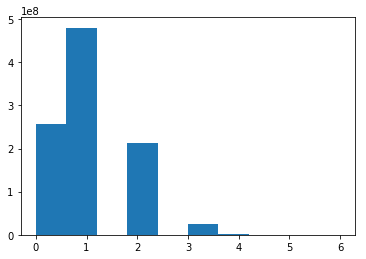

In [136]:
plt.hist(correlation_matrix_flat);

In [65]:
find_similar_movies(8)[0:10]

array([2185694,  154152,  392728,      10,      12, 1185422, 4286538,
       4318194, 4322280,  336693], dtype=int64)

In [68]:
max_sim = dot_prod_movies_df.loc[8].max()

In [92]:
x= dot_prod_movies_df.loc[12]

In [96]:
x[x.index!=12]

8          3
10         3
25         1
91         2
417        1
439        1
443        0
628        1
833        1
1223       1
1740       1
2101       0
2130       0
2354       1
2844       0
3740       0
3863       1
4099       0
4100       1
4101       1
4210       1
4395       1
4457       0
4518       1
4546       1
4936       1
4972       0
5074       1
5078       0
5530       0
          ..
7942708    0
7949046    0
7959216    0
7967954    0
7983794    1
7983844    1
8005338    0
8043254    0
8054150    0
8075496    1
8079546    0
8080268    0
8080556    1
8088944    0
8092252    0
8102036    0
8106570    1
8119752    0
8123286    0
8140564    0
8144778    1
8144868    0
8206708    0
8289196    1
8324578    0
8335880    0
8342748    0
8342946    0
8402090    0
8439854    0
Name: 12, Length: 31244, dtype: int64

In [71]:
max_sim = dot_prod_movies_df.loc[8].max()
arr = (dot_prod_movies_df.loc[8]==max_sim)
np.array(arr[arr ==True].index)

array([      8,      10,      12,  154152,  392728, 2185694], dtype=int64)

In [97]:
def find_similar_movies(movie_id):  # , content_size = 31):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # by doing everything >0 this keep suggesting odd not seen movies
    #arr = dot_prod_movies_df.loc[movie_id].sort_values(ascending=False)>0 # higher than 0, more similar
    
    # only using highest sim
    x = dot_prod_movies_df.loc[movie_id]
    # maximum correlation exclusing itself
    max_sim = x[x.index!=movie_id].max()
    arr = (dot_prod_movies_df.loc[movie_id]==max_sim)
    movie_id_list = np.array(arr[arr ==True].index)
    similar_movies = np.setdiff1d(movie_id_list,[movie_id],assume_unique=True) # drop itself

    return similar_movies


def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies.movie_id.isin(movie_ids)].movie.values)

    return movie_lst

def user_watched_review():
    '''
    INPUT

    OUTPUT
    review_dict - user watched movies and ratings in pandas
    '''    
    review_dict_movie = {}
    
    user_list = reviews_descend_short.user_id.unique()
    for user in user_list:
        review_dict_movie[user] = reviews_descend_short[reviews_descend_short.user_id == user][['movie_id','rating']]

    
    return user_list, review_dict_movie
    

def make_recs(max_rec=10):
    '''
    INPUT
    None
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''

    user_list = reviews_descend_short.user_id.unique()
    recs = {}
    bar = progressbar.ProgressBar()
    for user in bar(user_list):
        rec_per_user = []
        seen_movie_sorted_byrating = reviews_descend_short[reviews_descend_short.user_id == user]['movie_id'].values
        # start by movies user rated best
        for movie in seen_movie_sorted_byrating: 
            #movies similar not in seen by user
            tmp_rec = np.setdiff1d(find_similar_movies(movie),seen_movie_sorted_byrating, assume_unique=True)  
            rec_per_user.extend(tmp_rec)
            rec_per_user = list(set(rec_per_user))
            
            if(len(rec_per_user)>=max_rec):
                rec_per_user = rec_per_user[0:max_rec]
                break
                
        recs[user] = get_movie_names(rec_per_user)
                   
    return recs

In [98]:
recs = make_recs(10)

100% |########################################################################|


### How Did We Do?

Now that you have made the recommendations, how did we do in providing everyone with a set of recommendations?

`4.` Use the cells below to see how many individuals you were able to make recommendations for, as well as explore characteristics about individuals for whom you were not able to make recommendations.  

In [100]:
user_list

array([    1,     2,     3, ..., 53966, 53967, 53968], dtype=int64)

In [101]:
recs[2]

['2046 (2004)',
 'Code 46 (2003)',
 'The Giver (2014)',
 'Womb (2010)',
 'Another Earth (2011)',
 'Lucia (2013)',
 'Beyond (2014)',
 'Parts Per Billion (2014)',
 'I Origins (2014)',
 'Órbita 9 (2017)']

In [102]:
recs[730]

['Sillaui dalbam (2001)',
 'Les filles du botaniste (2006)',
 'Hereafter (2010)',
 'Genius (2016)',
 'Ek Main Aur Ekk Tu (2012)',
 'A Girl Walks Home Alone at Night (2014)',
 'Luton (2013)',
 'Rest Days (2014)',
 'Freetown (2015)',
 'Naciye (2015)']

In [103]:
recs[1]

['Change of Habit (1969)',
 'Jakob, der Lügner (1974)',
 'The Thin Blue Line (1988)',
 'Things Change (1988)',
 'Casino (1995)',
 'Jägarna (1996)',
 'Kama Sutra: A Tale of Love (1996)',
 'Kansas City (1996)',
 'Snake Eyes (1998)',
 'Aamne - Saamne (1967)']

In [104]:
recs[53966]

['Mulholland Dr. (2001)',
 'Oldeuboi (2003)',
 'The Good German (2006)',
 'Inland Empire (2006)',
 'Köld slóð (2006)',
 'La mujer sin cabeza (2008)',
 'Penthouse North (2013)',
 'The Dinner (2017)',
 'Dartmoor Killing (2015)',
 'Missing: Sarajin Yeoja (2016)']

In [107]:
user_list

array([    1,     2,     3, ..., 53966, 53967, 53968], dtype=int64)

In [109]:
users_with_all_recs = [user for user in list(recs.keys()) if (len(recs[user])>=10)]
print(len(users_with_all_recs))

51972


In [110]:
no_recs = [user for user in list(recs.keys()) if (len(recs[user])==0)]
print(len(no_recs))

0


In [111]:
users_without_all_recs = [user for user in list(recs.keys()) if (len(recs[user])<10 and len(recs[user])>0)]
print(len(users_without_all_recs))

1996


In [112]:

print("There were {} users without all 10 recommendations we would have liked to have.".format(len(users_without_all_recs)))
print("There were {} users with all 10 recommendations we would like them to have.".format(len(users_with_all_recs)))
print("There were {} users with no recommendations at all!".format(len(no_recs)))

There were 1996 users without all 10 recommendations we would have liked to have.
There were 51972 users with all 10 recommendations we would like them to have.
There were 0 users with no recommendations at all!


In [84]:
# Closer look at individual user characteristics - this may help it was from an earlier notebook
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = user_by_movie.loc[user_id][user_by_movie.loc[user_id].isnull() == False].index.values

    return get_movie_names(movies)


movies_watched(189)

['El laberinto del fauno (2006)']

In [113]:
print('watched',movies_watched(2))
print('------------------')
print('top rated watch', get_movie_names(reviews_descend_short[reviews_descend_short.user_id == 2]['movie_id'].values))
print('------------------')
print('10 recommended',recs[2])

watched ['Marie Antoinette (2006)', 'Life of Pi (2012)', 'Dallas Buyers Club (2013)', 'World War Z (2013)', 'Lone Survivor (2013)', 'Two Lovers (2008)', 'August: Osage County (2013)', 'In the Heart of the Sea (2015)', 'Straight Outta Compton (2015)', 'Deadpool (2016)', 'Disconnect (2012)', 'Gravity (2013)', 'Captain Phillips (2013)', 'The Intouchables (2011)', 'Her (2013)', 'All Is Lost (2013)', '12 Years a Slave (2013)', 'Frozen (2013)', 'The Intern (2015)', 'Mission: Impossible - Rogue Nation (2015)', 'The Longest Ride (2015)', 'Chef (2014)', 'Spy (2015)']
------------------
top rated watch ['Marie Antoinette (2006)', 'Life of Pi (2012)', 'Dallas Buyers Club (2013)', 'World War Z (2013)', 'Lone Survivor (2013)', 'Two Lovers (2008)', 'August: Osage County (2013)', 'In the Heart of the Sea (2015)', 'Straight Outta Compton (2015)', 'Deadpool (2016)', 'Disconnect (2012)', 'Gravity (2013)', 'Captain Phillips (2013)', 'The Intouchables (2011)', 'Her (2013)', 'All Is Lost (2013)', '12 Years

In [114]:
print('watched',movies_watched(1))
print('------------------')
print('top rated watch', get_movie_names(reviews_descend_short[reviews_descend_short.user_id == 1]['movie_id'].values))
print('------------------')
print('10 recommended',recs[1])

watched ['The Godfather (1972)', 'Heat (1995)']
------------------
top rated watch ['The Godfather (1972)', 'Heat (1995)']
------------------
10 recommended ['Change of Habit (1969)', 'Jakob, der Lügner (1974)', 'The Thin Blue Line (1988)', 'Things Change (1988)', 'Casino (1995)', 'Jägarna (1996)', 'Kama Sutra: A Tale of Love (1996)', 'Kansas City (1996)', 'Snake Eyes (1998)', 'Aamne - Saamne (1967)']


In [116]:
print('watched',movies_watched(100))
print('------------------')
print('top rated watch', get_movie_names(reviews_descend_short[reviews_descend_short.user_id == 100]['movie_id'].values))
print('------------------')
print('10 recommended',recs[100])

watched ['Artifact (2012)']
------------------
top rated watch ['Artifact (2012)']
------------------
10 recommended ['Moog (2004)', 'The Devil and Daniel Johnston (2005)', "Metal: A Headbanger's Journey (2005)", 'Jonas Brothers: The 3D Concert Experience (2009)', 'Filmage: The Story of Descendents/All (2013)', 'As the Palaces Burn (2014)', 'One Direction: Going Our Way (2013)', 'Austin to Boston (2014)', 'Score: A Film Music Documentary (2016)', 'Residenté (2017)']


In [118]:
user_id = 4
print('watched',movies_watched(user_id))
print('------------------')
print('top rated watch', get_movie_names(reviews_descend_short[reviews_descend_short.user_id == user_id]['movie_id'].values))
print('------------------')
print('10 recommended',recs[user_id])

watched ['Iron Man 3 (2013)']
------------------
top rated watch ['Iron Man 3 (2013)']
------------------
10 recommended ['Planet of the Apes (2001)', 'X2 (2003)', 'Timeline (2003)', 'Iron Man (2008)', 'Stealth (2005)', 'X-Men: First Class (2011)', 'Deadpool (2016)', 'Robot Overlords (2014)', 'Star Trek Beyond (2016)', 'Age of Ice (2014)']


In [121]:
user_id = 1111
print('watched',movies_watched(user_id))
print('------------------')
print('top rated watch', get_movie_names(reviews_descend_short[reviews_descend_short.user_id == user_id]['movie_id'].values))
print('------------------')
print('10 recommended',recs[user_id])

watched ['Draft Day (2014)']
------------------
top rated watch ['Draft Day (2014)']
------------------
10 recommended ['Remember the Titans (2000)', 'Mean Machine (2001)', 'Swimming Upstream (2003)', 'We Are Marshall (2006)', 'Hamill (2010)', 'Hurricane Season (2009)', 'Allez, Eddy! (2012)', 'Blinder (2013)', 'La petite reine (2014)', 'Palio (2015)']


## discussion

- May be a good idea is after identifying most similar movies (look for max sim) that user has not seen yet, look at those suggested list,
and filter them again based on average reviews from other users.
- Also can more fine tuned year of the movies, instead of dividing it into 3 centrury 1800s/1900s/2000s, do more era, 50s, 60s,...
- can also look at when user generally watch movies, and suggest recommendations during that time frame
- also foreign movie category is needed

### Now What?   (see above discussion)

Well, if you were really strict with your criteria for how similar two movies are (like I was initially), then you still have some users that don't have all 10 recommendations (and a small group of users who have no recommendations at all). 

As stated earlier, recommendation engines are a bit of an **art** and a **science**.  There are a number of things we still could look into - how do our collaborative filtering and content based recommendations compare to one another? How could we incorporate user input along with collaborative filtering and/or content based recommendations to improve any of our recommendations?  How can we truly gain recommendations for every user?

`5.` In this last step feel free to explore any last ideas you have with the recommendation techniques we have looked at so far.  You might choose to make the final needed recommendations using the first technique with just top ranked movies.  You might also loosen up the strictness in the similarity needed between movies.  Be creative and share your insights with your classmates!

In [ ]:
# Cells for exploring